# Table of Contents

[Introduction](#1)

[Section 1: Preparing the Data](#2)

[Section 2: Training and Testing the Linear Model For Each Region](#3)
- [PART A: Splitting the Data Into Training and Validation Sets](#3.1)
- [PART B: Training the Model](#3.2)
- [PART C: Saving the Predictions and Correct Answers](#3.3)
- [PART D: Printing the Average Volume of Predicted Reserves and Model RMSE](#3.4)
- [PART E: Analyzing the Results](#3.5)

[Section 3: Preparing For Profit Calculations](#4)
- [PART A: Storing All Key Values For Calculations (In Separate Variables)](#4.1)
- [PART B.1: Calculating the Volume of Reserves Sufficient For Developing a New Well](#4.2)
- [PART B.2: Comparing the Obtained Values With the Average Volume of Reserves In Each Region](#4.3)
- [PART C: Findings Found During the Preparation For the Profit Calculation](#4.4)

[Section 4: Writing a Function For Calculating Profit](#5)
- [PART A: Picking the 500 Locations With the Best Predicted Values](#5.1)
- [PART B: Summarizing the Target Volume of Reserves](#5.2)
- [PART C.1: Suggesting a Region For Oil Wells Development](#5.3)
- [PART C.2: Calculating the Profit For the Obtained Volume of Reserves (Based On the Best 200 Locations)](#5.4)

[Section 5: Calculating Risks and Profits For Each Region](#6)
- [PART A: Using the Bootstrapping Technique (With 1,000 Samples) to Find the Distribution of Profit](#6.1)
- [PART B.1: Calculating the Average Profit Using a 95% Confidence Interval](#6.2)
- [PART B.2: Also Calculating the Risk of Losses (i.e. Negative Profit)](#6.3)
- [PART C: Suggesting a Region for Development of Oil Wells](#6.4)

[Conclusion](#7)

# Introduction <a id=1></a>

I am a data scientist for the **OilyGiant** mining company who is tasked with finding the most profitable location, among three regions, for new wells. 

To help me find the best location, I will follow the steps below:

1) Collect the oil well parameters, oil quality and volume of reserves (in thousands of barrels), in the selected region

2) Build a model for predicting the volume of reserves in the new wells

3) Pick the oil wells with the highest estimated values

4) Pick the region with the highest total profit for the selected oil wells

To help me complete those steps, I have data on oil samples from three regions, where the parameters of each oil well are already known. 

Since this is a regression task (and not classification), a linear regression machine learning model is appropriate to build here. 

Furthermore, I will use the Bootstrapping technique to not only analyze potential profit, but also to assess risks. In fact, no region with a 2.5% or higher risk of losses should even be considered.

When exploring a region, 500 points will be studied, of which the best 200 will be picked for the profit calculation. The budget for developing 200 oil wells is 100 USD million dollars, and the revenue from one unit of product is 4,500 dollars.

# Section 1: Preparing the Data <a id=2></a>

It is good practice to have all the libraries needed for a project be imported at the very beginning.

In [1]:
from scipy import stats as st
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sympy import symbols, solve_univariate_inequality
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

Each of the three regions have their geological exploration data stored in its own csv file. 

The names of the columns, and what data each column contains, are as follows:

**id** — The unique identifier of an oil well

**f0, f1, f2** — Three features of points (their specific meaning is unimportant, but the features themselves are significant)

**product** — The volume of reserves in the oil well (in thousands of barrels).

In [2]:
geo_data_0 = pd.read_csv('geo_data_0.csv')
geo_data_1 = pd.read_csv('geo_data_1.csv')
geo_data_2 = pd.read_csv('geo_data_2.csv')

It is always a good idea to apply the **info()** function to each dataframe to see if there are any null values, and also to ensure that the Dtypes are appropriate.

Personally, I always like to apply the **sample(10)** function to each dataframe as well, so that I get an idea of what the data looks like.

In [3]:
geo_data_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [4]:
display(geo_data_0.sample(10))

,id,f0,f1,f2,product
37327,79RFg,0.092001,-0.247611,9.801970,178.755976
46334,5ii9a,-0.020903,0.903616,1.086500,73.957649
28086,RWTZP,1.146803,0.088580,4.304908,130.851895
44278,jQDWH,0.916034,0.781965,-0.079957,73.229034
33520,Hy2mj,2.028580,0.426121,3.471059,92.926944
93071,aL9Z7,-0.944251,0.385020,1.131171,38.619728
46431,XBjwr,-0.105361,0.899430,2.645754,111.615669
51314,efEwB,1.086040,-0.279805,4.240068,136.773981
82896,sPuhf,-0.117647,0.445094,2.642475,50.371602
99521,pdioJ,1.663170,-0.092155,4.283865,72.095673


In [5]:
geo_data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [6]:
display(geo_data_1.sample(10))

,id,f0,f1,f2,product
97678,s2EUv,9.076493,-0.991985,4.011131,107.813044
29404,Ny6O2,13.514021,-6.981982,0.007154,0.000000
81584,0D7LZ,19.670248,3.154501,1.001259,26.953261
34597,W2VWN,1.576573,-6.319410,0.001849,0.000000
80403,l4T4C,-12.490914,-2.950544,1.001885,30.132364
95629,M4ZHc,-16.243547,-6.119213,5.009827,137.945408
75886,sDg39,9.252288,-7.243594,3.005104,80.859783
38577,44NZJ,3.466574,-10.008024,4.000548,107.813044
90254,bEkZW,-4.741177,-8.268871,-0.006882,3.179103
17479,Rms9Y,-10.121801,-5.788455,3.001108,84.038886


In [7]:
geo_data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [8]:
display(geo_data_2.sample(10))

,id,f0,f1,f2,product
94169,m7BTF,-0.582695,-0.918485,8.560383,143.868408
66304,tau3V,-2.221197,1.602754,1.498328,113.000627
5741,8dPNf,-1.252540,0.703374,4.851259,25.619409
29189,UsSMM,-2.120403,1.131971,2.605964,115.371631
28048,9EMl6,-2.057686,-3.241810,-2.701796,89.458467
93057,6GTtf,1.052478,-0.847452,-0.540606,151.341000
22077,9Mi5v,-1.986617,1.284666,3.764837,101.886789
32811,EgjCk,1.110904,-1.425760,3.443274,85.064018
22333,QQysh,0.469354,-1.162353,-0.787256,85.195287
4290,PZFeg,0.789726,-0.246454,-3.692025,89.061758


Everything looks good! There are no null values, and all of the Dtypes make sense.

# Section 2: Training and Testing the Linear Model For Each Region <a id=3></a>

**<u>PART A</u>: Splitting the Data Into Training and Validation Sets** <a id=3.1></a>

When splitting data into a training set and a validation set, it is good practice for the training set to receive 75% of the data, and consequently the validation set receives the remaining 25%. Notice that I am not including the **id** column in the features dataframes. This is because each **id** value is unique, and therefore including them would run the risk of the model being overfitted.

In [9]:
features_geo_0 = geo_data_0.drop(['id', 'product'], axis = 1)
target_geo_0 = geo_data_0['product']

features_geo_0_train, features_geo_0_valid, target_geo_0_train, target_geo_0_valid = train_test_split(
    features_geo_0, target_geo_0, test_size = 0.25, random_state = 12345)

In [10]:
features_geo_1 = geo_data_1.drop(['id', 'product'], axis = 1)
target_geo_1 = geo_data_1['product']

features_geo_1_train, features_geo_1_valid, target_geo_1_train, target_geo_1_valid = train_test_split(
    features_geo_1, target_geo_1, test_size = 0.25, random_state = 12345)

In [11]:
features_geo_2 = geo_data_2.drop(['id', 'product'], axis = 1)
target_geo_2 = geo_data_2['product']

features_geo_2_train, features_geo_2_valid, target_geo_2_train, target_geo_2_valid = train_test_split(
    features_geo_2, target_geo_2, test_size = 0.25, random_state = 12345)

**<u>PART B</u>: Training the Model** <a id=3.2></a>

As mentioned in the Introduction, a linear regression machine learning model is suitable for this project.

In [12]:
model_geo_0 = LinearRegression()
model_geo_0.fit(features_geo_0_train, target_geo_0_train)

LinearRegression()

In [13]:
model_geo_1 = LinearRegression()
model_geo_1.fit(features_geo_1_train, target_geo_1_train)

LinearRegression()

In [14]:
model_geo_2 = LinearRegression()
model_geo_2.fit(features_geo_2_train, target_geo_2_train)

LinearRegression()

**<u>PART C</u>: Saving the Predictions and Correct Answers** <a id=3.3></a>

By storing each region's predicted values into their own variables, I am saving them. 

Furthermore, the correct answers are stored in the variables **target_geo_0_valid**, **target_geo_1_valid**, and **target_geo_2_valid**, respectively.

In [15]:
predictions_geo_0_valid = model_geo_0.predict(features_geo_0_valid)
predictions_geo_0_valid = pd.Series(predictions_geo_0_valid)

In [16]:
predictions_geo_1_valid = model_geo_1.predict(features_geo_1_valid)
predictions_geo_1_valid = pd.Series(predictions_geo_1_valid)

In [17]:
predictions_geo_2_valid = model_geo_2.predict(features_geo_2_valid)
predictions_geo_2_valid = pd.Series(predictions_geo_2_valid)

**<u>PART D</u>: Printing the Average Volume of Predicted Reserves and Model RMSE** <a id=3.4></a>

Notice that I am deliberately rounding the values to two decimal places to make the numbers easier to read.

In [18]:
print("The average volume of actual reserves in Region 0 is:", round(target_geo_0_valid.mean(), 2))
print("The average volume of predicted reserves in Region 0 is:", round(predictions_geo_0_valid.mean(), 2))

The average volume of actual reserves in Region 0 is: 92.08
The average volume of predicted reserves in Region 0 is: 92.59


In [19]:
print("The standard deviation of the volume of actual reserves in Region 0 is:", round(target_geo_0_valid.std(), 2))
print("The standard deviation of the volume of predicted reserves in Region 0 is:", round(predictions_geo_0_valid.std(), 2))

The standard deviation of the volume of actual reserves in Region 0 is: 44.29
The standard deviation of the volume of predicted reserves in Region 0 is: 23.18


In [20]:
rmse_geo_0 = mean_squared_error(target_geo_0_valid, predictions_geo_0_valid)**0.5
print("RMSE of the linear regression model on the validation set for Region 0:", round(rmse_geo_0, 2))

RMSE of the linear regression model on the validation set for Region 0: 37.58


In [21]:
print("The average volume of actual reserves in Region 1 is:", round(target_geo_1_valid.mean(), 2))
print("The average volume of predicted reserves in Region 1 is:", round(predictions_geo_1_valid.mean(), 2))

The average volume of actual reserves in Region 1 is: 68.72
The average volume of predicted reserves in Region 1 is: 68.73


In [22]:
print("The standard deviation of the volume of actual reserves in Region 1 is:", round(target_geo_1_valid.std(), 2))
print("The standard deviation of the volume of predicted reserves in Region 1 is:", round(predictions_geo_1_valid.std(), 2))

The standard deviation of the volume of actual reserves in Region 1 is: 46.02
The standard deviation of the volume of predicted reserves in Region 1 is: 46.01


In [23]:
rmse_geo_1 = mean_squared_error(target_geo_1_valid, predictions_geo_1_valid)**0.5
print("RMSE of the linear regression model on the validation set for Region 1:", round(rmse_geo_1, 2))

RMSE of the linear regression model on the validation set for Region 1: 0.89


In [24]:
print("The average volume of actual reserves in Region 2 is:", round(target_geo_2_valid.mean(), 2))
print("The average volume of predicted reserves in Region 2 is:", round(predictions_geo_2_valid.mean(), 2))

The average volume of actual reserves in Region 2 is: 94.88
The average volume of predicted reserves in Region 2 is: 94.97


In [25]:
print("The standard deviation of the volume of actual reserves in Region 2 is:", round(target_geo_2_valid.std(), 2))
print("The standard deviation of the volume of predicted reserves in Region 2 is:", round(predictions_geo_2_valid.std(), 2))

The standard deviation of the volume of actual reserves in Region 2 is: 44.9
The standard deviation of the volume of predicted reserves in Region 2 is: 19.85


In [26]:
rmse_geo_2 = mean_squared_error(target_geo_2_valid, predictions_geo_2_valid)**0.5
print("RMSE of the linear regression model on the validation set for Region 2:", round(rmse_geo_2, 2))

RMSE of the linear regression model on the validation set for Region 2: 40.03


**<u>PART E</u>: Analyzing the Results** <a id=3.5></a>

The results for Region 1 look great! The mean and standard deviation of the predicted values are very close to those of the actual values. 

Furthermore, the RMSE value is ***very*** small, about 0.89, which suggests that model truly does a good job of predicting Region 1's **product** values.

Unfortunately, the models for Regions 0 and 2 are not as accurate. For both Region 0 and 2, the average volume of predicted reserves is very similar to the actual values, however the standard deviations are quite different. 

In both regions, the predicted standard deviation is roughly half that of the actual standard deviations. Furthermore, the RSME values are quite large, about 37.58 for Region 0 and about 40.03 for Region 2.

I would like to visualize the differences in the distributions between the actual and the predicted values. Boxplots are appropriate to use here. 

The Region 0 plots are blue, the Region 1 plots are green, and the Region 2 plots are orange, to make it easier to keep track of them.

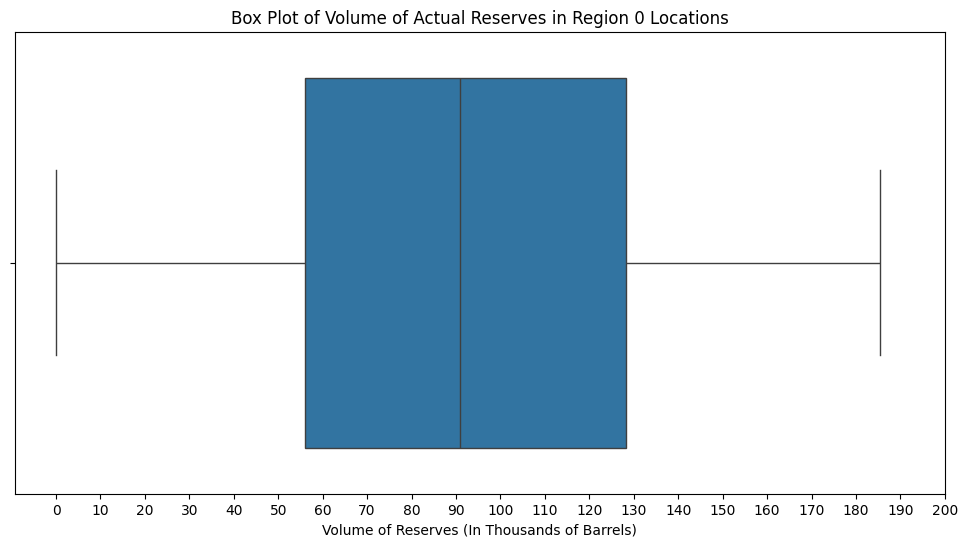

In [27]:
target_geo_0_valid_df = target_geo_0_valid.to_frame(name = 'product')

plt.figure(figsize = (12, 6))
sns.boxplot(data = target_geo_0_valid_df, x = 'product', orient = 'h')

plt.title('Box Plot of Volume of Actual Reserves in Region 0 Locations')
plt.xlabel('Volume of Reserves (In Thousands of Barrels)')
plt.xticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200])
plt.ylabel('')
plt.show()

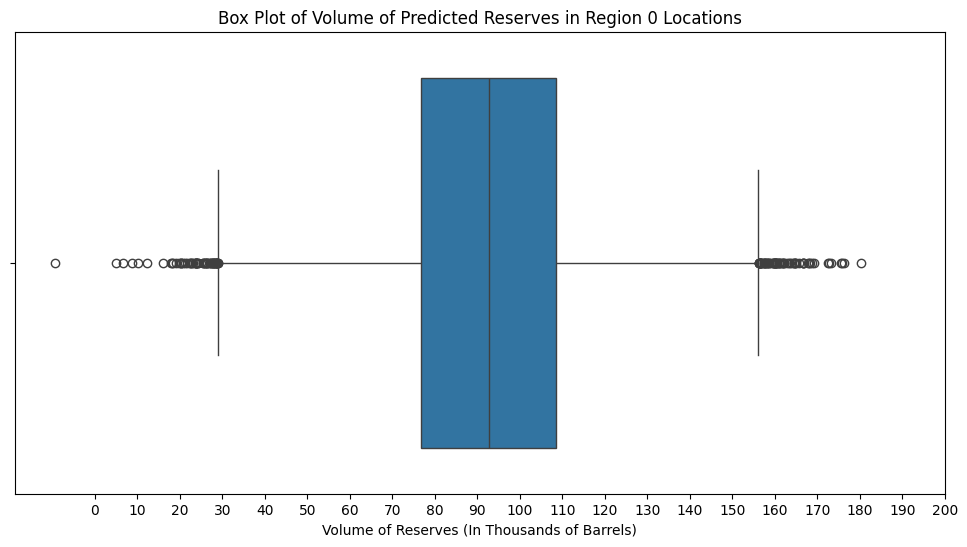

In [28]:
predictions_geo_0_valid_df = predictions_geo_0_valid.to_frame(name = 'product')

plt.figure(figsize = (12, 6))
sns.boxplot(data = predictions_geo_0_valid_df, x = 'product', orient = 'h')

plt.title('Box Plot of Volume of Predicted Reserves in Region 0 Locations')
plt.xlabel('Volume of Reserves (In Thousands of Barrels)')
plt.xticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200])
plt.ylabel('')
plt.show()

Interesting! Though the medians are very similar, the predicted spread in the values is ***much*** smaller than the actual spread.

In fact, the boxplot of the predicted spread has numerous outliers, whereas in actuality there are no outliers.

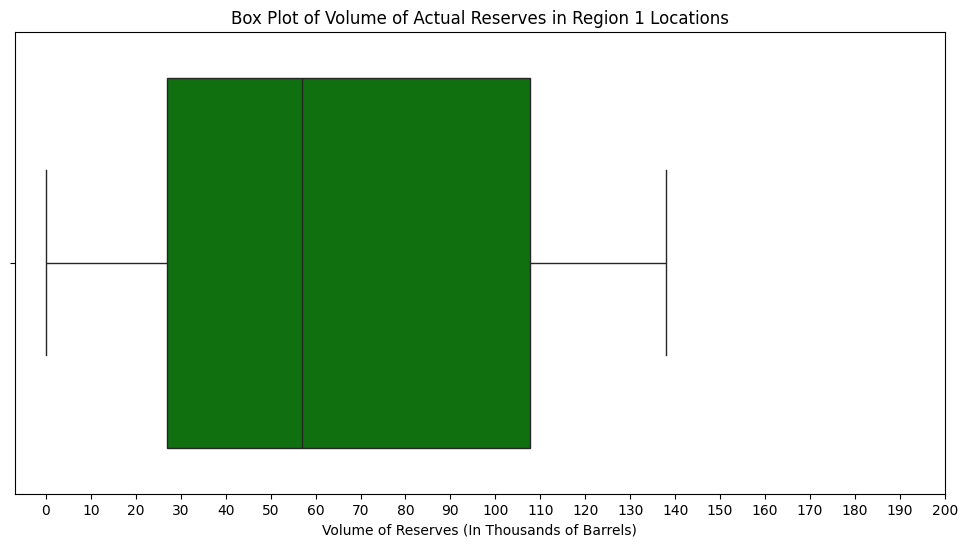

In [29]:
target_geo_1_valid_df = target_geo_1_valid.to_frame(name = 'product')

plt.figure(figsize = (12, 6))
sns.boxplot(data = target_geo_1_valid_df, x = 'product', orient = 'h', color = 'green')

plt.title('Box Plot of Volume of Actual Reserves in Region 1 Locations')
plt.xlabel('Volume of Reserves (In Thousands of Barrels)')
plt.xticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200])
plt.ylabel('')
plt.show()

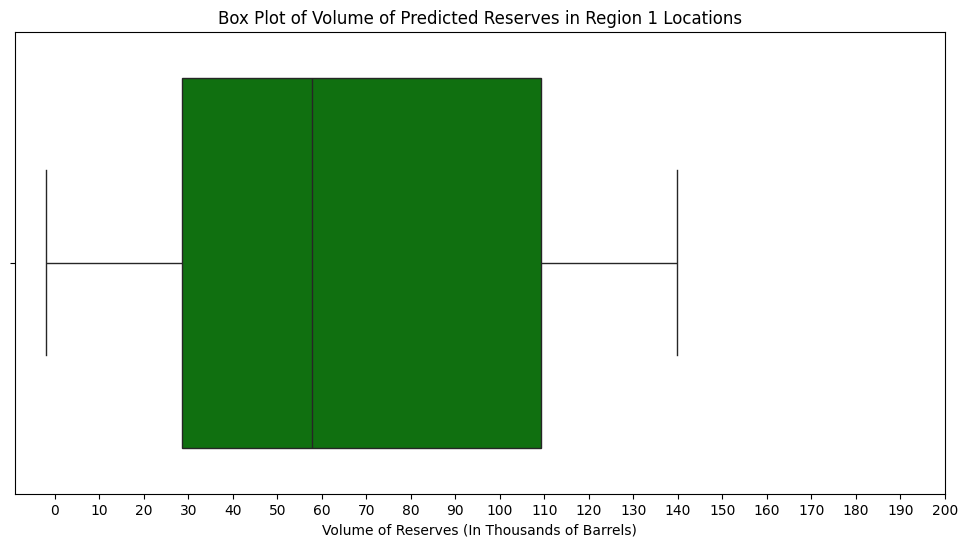

In [30]:
predictions_geo_1_valid_df = predictions_geo_1_valid.to_frame(name = 'product')

plt.figure(figsize = (12, 6))
sns.boxplot(data = predictions_geo_1_valid_df, x = 'product', orient = 'h', color = 'green')

plt.title('Box Plot of Volume of Predicted Reserves in Region 1 Locations')
plt.xlabel('Volume of Reserves (In Thousands of Barrels)')
plt.xticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200])
plt.ylabel('')
plt.show()

As expected, the boxplots for Region 1 are extremely similar.

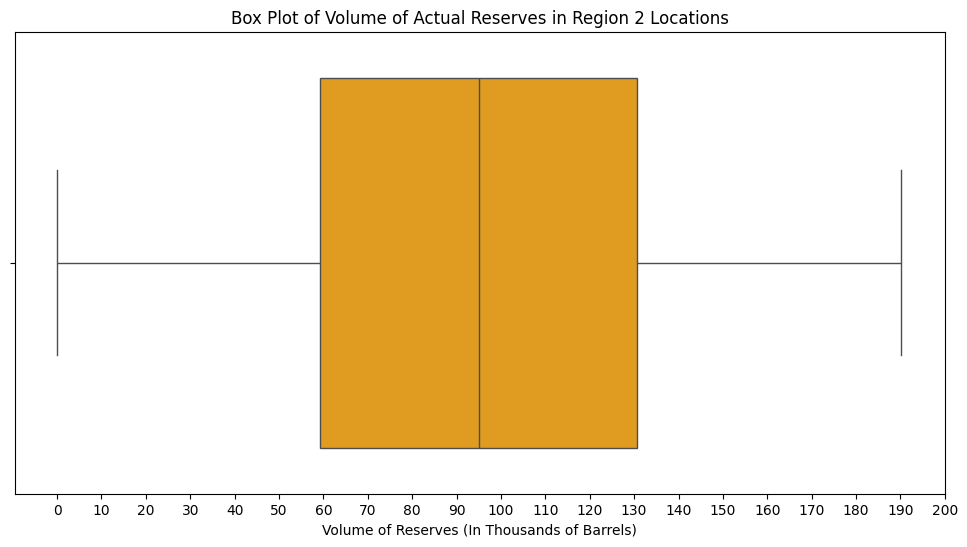

In [31]:
target_geo_2_valid_df = target_geo_2_valid.to_frame(name = 'product')

plt.figure(figsize = (12, 6))
sns.boxplot(data = target_geo_2_valid_df, x = 'product', orient = 'h', color = 'orange')

plt.title('Box Plot of Volume of Actual Reserves in Region 2 Locations')
plt.xlabel('Volume of Reserves (In Thousands of Barrels)')
plt.xticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200])
plt.ylabel('')
plt.show()

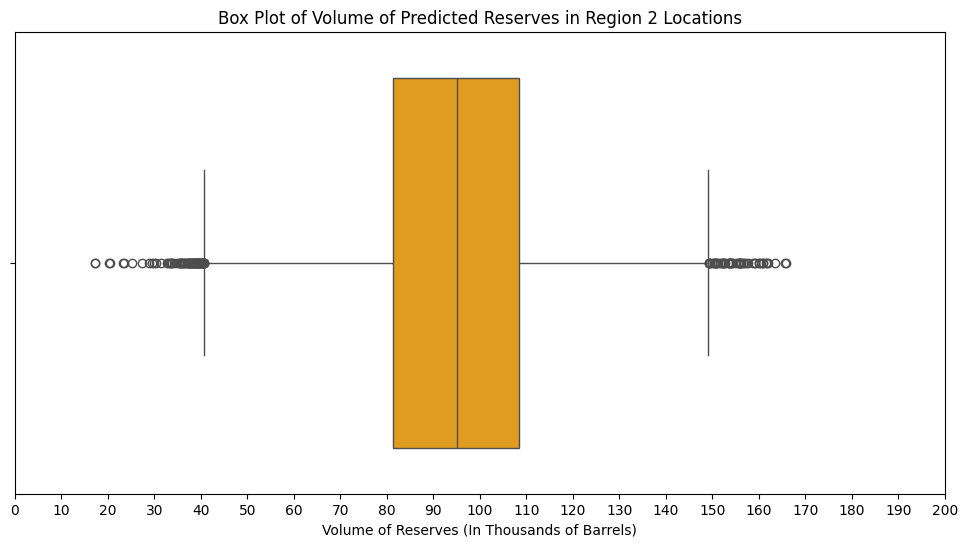

In [32]:
predictions_geo_2_valid_df = predictions_geo_2_valid.to_frame(name = 'product')

plt.figure(figsize = (12, 6))
sns.boxplot(data = predictions_geo_2_valid_df, x = 'product', orient = 'h', color = 'orange')

plt.title('Box Plot of Volume of Predicted Reserves in Region 2 Locations')
plt.xlabel('Volume of Reserves (In Thousands of Barrels)')
plt.xticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200])
plt.ylabel('')
plt.show()

The boxplots of Region 2 are just like those of Region 0 in the sense that the predicted values have a ***much*** smaller spread than the actual values, to the point that the predicted boxplot has numerous outliers despite the actual boxplot not having any.

I also notice that the boxplots of Regions 0 and 2 suggest that their distributions of volume of reserves are approximately symmetrical, whereas the distributions for Region 1 are right-skewed, as evidenced by how the median is much closer to the 1st quartile value than it is to the 3rd quartile value.

# Section 3: Preparing For Profit Calculations <a id=4></a>

**<u>PART A</u>: Storing All Key Values For Calculations (In Separate Variables)** <a id=4.1></a>

**OilyGiant's** total budget for developing 200 wells is 100,000,000 USD. Assuming each well costs the same to develop, the budget for each of the 200 wells is 500,000 USD. The revenue from each unit of product is 4,500 USD. 

In [33]:
total_budget = 100000000
budget_per_well = total_budget/200
revenue_per_product = 4500

**<u>PART B.1</u>: Calculating the Volume of Reserves Sufficient For Developing a New Well** <a id=4.2></a>

In order for a well to be worth developing, it needs to make the company profit. Profit = Revenue – Cost, so I need to figure out how many units of product is the minimum needed so that the total revenue from the oil of a well is greater than the cost of developing the well, which I found earlier to be 500,000 USD. 

In [34]:
min_product_needed = symbols('min_product_needed')
solution = solve_univariate_inequality(revenue_per_product*min_product_needed - budget_per_well > 0, min_product_needed)
print(solution)

(111.111111111111 < min_product_needed) & (min_product_needed < oo)


Note that 111.111111111111 units of product is equivalent to 111.111111111111*1000 = 111,111.111111111 barrels of oil. 

Assuming that **OilyGiant** only sells oil in whole barrels, a well would need to have at least 111,112 barrels worth of oil to net a profit.

This result is concerning because **Section 2** <u>**Part D**</u> implies that ***on average*** none of the three regions have that amount of product. 

Fortunately, it is likely that ***some*** locations in each region have at least that amount of product, and I investigate this later in this project. 

**<u>PART B.2</u>: Comparing the Obtained Values With the Average Volume of Reserves In Each Region** <a id=4.3></a>

Recall that in **Section 2** <u>**Part D**</u> I found the average volume of reserves in each region. The average units of product in each region, rounded to the nearest whole number, are 92 for Region 0, 69 for Region 1, and 95 for Region 2. As mentioned in **Section 3** <u>**Part B.1**</u>, it is concerning in none of the three regions is the average location able to net **OilyGiant** a profit. Hopefully at least one region has (at least) 200 locations that each have at least 112 units of product! It is worth noting that since Region 2 has the largest average, it might be the region with the best 200 locations.

**<u>PART C</u>: Findings Found During the Preparation For the Profit Calculation** <a id=4.4></a>

I must stress that while all three regions have potential to be lucrative, Region 1 has, on average, only about 70% to 75% of the volume of oil that Regions 0 and 2 have. This is unfortunate because Region 1's model is the one whose predictions are, by far, the most accurate. When I calculate the profit of the 200 best wells in each region, I will know for sure, but I suspect that Region 1 will ultimately not be selected as the region where **OilyGiant** should develop wells.

# Section 4: Writing a Function For Calculating Profit <a id=5></a>

**<u>PART A</u>: Picking the 500 Locations With the Best Predicted Values** <a id=5.1></a>

Let's now sort the **predictions_geo_#_valid** values in descending order, and store the top 500 in new variables.

In [35]:
geo_0_top_500_predicted = predictions_geo_0_valid.sort_values(ascending = False).head(500)

In [36]:
geo_1_top_500_predicted = predictions_geo_1_valid.sort_values(ascending = False).head(500)

In [37]:
geo_2_top_500_predicted = predictions_geo_2_valid.sort_values(ascending = False).head(500)

**<u>PART B</u>: Summarizing the Target Volume of Reserves** <a id=5.2></a>

The **describe()** function is a convenient way to summarize the target volume of reserves in the top 500 best locations (as determined by my model).

Ultimately, I will have to pick the best 200 out of the top 500 locations in the region that would be the most profitable. 

Since 200 is 40% of 500, it is a good idea to have the **describe()** function display the 60th percentile values of each region because from the 60th percentile onward is where the best 200 **product** values are located.

Lastly, I also wrote code that displays the total sum of the 500 largest **product** values for each region.

In [38]:
geo_0_top_500_predicted.describe(percentiles = [0.25, 0.5, 0.6, 0.75])

count    500.000000
mean     148.367863
std        7.324618
min      139.907140
25%      142.793233
50%      146.584313
60%      148.328225
75%      152.064427
max      180.180713
dtype: float64

In [39]:
print('Total predicted units of product in the top 500 locations in Region 0:', 
      f"{(round(geo_0_top_500_predicted.sum())):,}")

Total predicted units of product in the top 500 locations in Region 0: 74,184


In [40]:
geo_1_top_500_predicted.describe(percentiles = [0.25, 0.5, 0.6, 0.75])

count    500.000000
mean     138.392535
std        0.343628
min      137.977632
25%      138.114239
50%      138.322828
60%      138.410558
75%      138.563965
max      139.818970
dtype: float64

In [41]:
print('Total predicted units of product in the top 500 locations in Region 1:', 
      f"{(round(geo_1_top_500_predicted.sum())):,}")

Total predicted units of product in the top 500 locations in Region 1: 69,196


In [42]:
geo_2_top_500_predicted.describe(percentiles = [0.25, 0.5, 0.6, 0.75])

count    500.000000
mean     142.325693
std        5.947563
min      135.591250
25%      137.720945
50%      140.864113
60%      142.405539
75%      145.040640
max      165.856833
dtype: float64

In [43]:
print('Total predicted units of product in the top 500 locations in Region 2:', 
      f"{(round(geo_2_top_500_predicted.sum())):,}")

Total predicted units of product in the top 500 locations in Region 2: 71,163


**<u>PART C.1</u>: Suggesting a Region For Oil Wells Development** <a id=5.3></a>

The results of <u>**Part B**</u> strongly imply that Region 0 has the best 200 locations (despite the fact that in **Section 3** Region 2 had the best locations, on average, when looking at 25,000 locations). In addition to Region 0 having the largest 60th percentile, 75th percentile, and max values of the three regions, Region 0 also has the largest min, 25th percentile, 50th percentile (i.e. median), and mean values. 

This observation implies that region 0 is the most lucrative not only when looking at the best 200 locations, but also when looking at the top 500. Hence, if for some reason a well cannot be developed in a top 200 location, **OilyGiant** would probably be able to find a good replacement somewhere else in the top 500.

Furthermore, Region 0 has the largest total sum of **product** values of the three regions, when looking at the top 500. I would think that it would also have the largest total sum for the best 200, but let's find out for sure!

In [44]:
print('Total predicted units of product in the top 200 locations in Region 0:', 
      f"{(round(geo_0_top_500_predicted.head(200).sum())):,}")

Total predicted units of product in the top 200 locations in Region 0: 31,102


In [45]:
print('Total predicted units of product in the top 200 locations in Region 1:', 
      f"{(round(geo_1_top_500_predicted.head(200).sum())):,}")

Total predicted units of product in the top 200 locations in Region 1: 27,746


In [46]:
print('Total predicted units of product in the top 200 locations in Region 2:', 
      f"{(round(geo_2_top_500_predicted.head(200).sum())):,}")

Total predicted units of product in the top 200 locations in Region 2: 29,604


Region 0 is indeed the one with the most total volume of oil in its best 200 locations!

**<u>PART C.2</u>: Calculating the Profit For the Obtained Volume of Reserves (Based On the Best 200 Locations)** <a id=5.4></a>

Let's now define a function that will calculate the profit of the top 200 locations in a set of 500 locations.

The function takes the target product values, the predicted product values, the revenue per unit of product, and the budget per well as arguments. 

(Recall that I defined the variables **revenue_per_barrel** and **budget_per_well** in Section 3.)

It sorts the locations by predicted product values in descending order, takes the top 200 locations, and finally takes the corresponding target product values and calculates profit. By using the dataframe that is returned, I can easy do useful calculations, such as find the mean, median, sum, etc.

In [47]:
def profit(target_values, predicted_values, revenue_per_product, budget_per_well):
    locations = pd.DataFrame({'target_values': target_values, 'predicted_values': predicted_values})
    locations_200_top = locations.sort_values(by = 'predicted_values', ascending = False).head(200)
    locations_200_top['profit'] = locations_200_top['target_values'] * revenue_per_product - budget_per_well
    return locations_200_top['profit']

I am curious to see the summary statistics regarding the expected profit values. Note that all of the values in this part are in USD.

In [48]:
profit(target_geo_0_valid.reset_index(drop = True), predictions_geo_0_valid, revenue_per_product, budget_per_well).describe()

count       200.000000
mean     166041.302157
std      113885.689521
min     -310584.586913
25%      101351.695548
50%      183576.434208
75%      252635.177366
max      329604.049145
Name: profit, dtype: float64

Lastly, let's see what my function predicts the total profit of the top 200 locations to be.

In [49]:
geo_0_top_200_expected_profit = profit(target_geo_0_valid.reset_index(drop = True), 
                                       predictions_geo_0_valid, revenue_per_product, budget_per_well).sum()

print('Total expected profit, in USD, of the top 200 locations in Region 0:', f"{round(geo_0_top_200_expected_profit):,}")

Total expected profit, in USD, of the top 200 locations in Region 0: 33,208,260


# Section 5: Calculating Risks and Profits For Each Region <a id=6></a>

**<u>PART A</u>: Using the Bootstrapping Technique (With 1,000 Samples) to Find the Distribution of Profit** <a id=6.1></a>

In this section I use bootstrapping to find 1000 samples of the profit values in 200 locations in the region.

On the next line I reset the indices of each **target_geo_X_valid** to make sure that they match those of the corresponding **predictions_geo_X_valid**.

In [50]:
target_geo_0_valid = target_geo_0_valid.reset_index(drop = True)
target_geo_1_valid = target_geo_1_valid.reset_index(drop = True)
target_geo_2_valid = target_geo_2_valid.reset_index(drop = True)

In [51]:
geo_0_first_state = np.random.RandomState(12345)

geo_0_bootstrapped_profit_values = pd.DataFrame(index = range(200), columns = range(1000))
    
for i in range(1000):
    subsample = target_geo_0_valid.sample(n = 500, replace = True, random_state = geo_0_first_state)
    target_values = subsample.values
    predicted_values = predictions_geo_0_valid.loc[subsample.index].values
    profit_values = profit(target_values, predicted_values, revenue_per_product, budget_per_well)
    geo_0_bootstrapped_profit_values[i] = profit_values.reset_index(drop = True)

Now I am curious to know, what is the distribution of how much money, in USD, would be made in profit if all 200 locations in a sample had the total sum of their oil sold? The boxplot on the next line shows this distribution. To reiterate, each distinct value in the following boxplot comes from adding together all 200 profit values in a particular column of the **geo_0_bootstrapped_profit_values** dataframe. Since each total profit value is so large, I deliberately divide them all by 1,000,000 meaning each number on the horizontal axis is in **MILLIONS** of USD. 

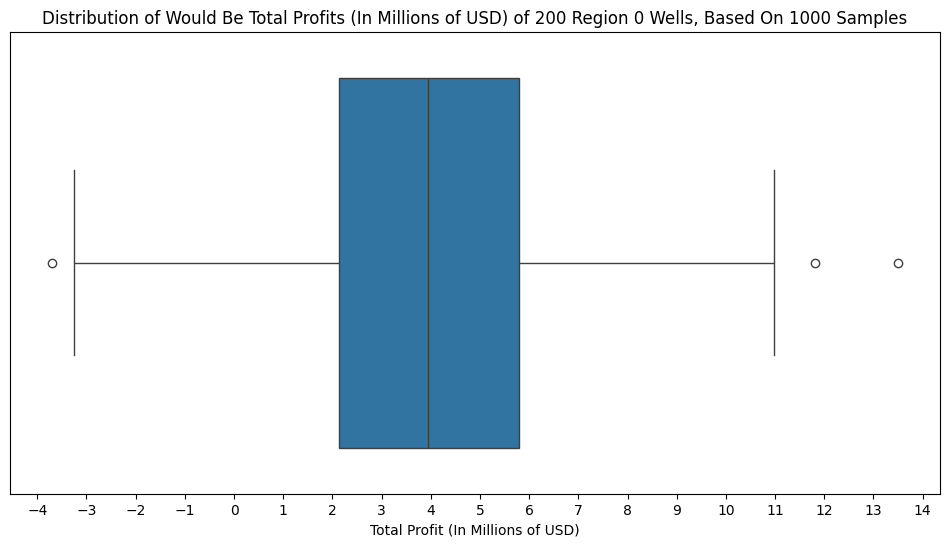

In [52]:
plt.figure(figsize = (12, 6))
sns.boxplot(data = geo_0_bootstrapped_profit_values.sum(axis = 0)/1000000, orient = 'h')

plt.title('Distribution of Would Be Total Profits (In Millions of USD) of 200 Region 0 Wells, Based On 1000 Samples')
plt.xlabel('Total Profit (In Millions of USD)')
plt.xticks([-4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])
plt.yticks([])
plt.show()

So that I know the values of some of the summary statistics, such as the 25th, 50th, 60th, and 75th percentiles, I use the **describe()** function.

In [53]:
geo_0_bootstrapped_profit_values_millions = geo_0_bootstrapped_profit_values/1000000
geo_0_bootstrapped_profit_values_millions.sum(axis = 0).describe()

count    1000.000000
mean        3.961650
std         2.666143
min        -3.695671
25%         2.139204
50%         3.950089
75%         5.793003
max        13.492669
dtype: float64

Now let's repeat the above process with Regions 1 and 2.

In [54]:
geo_1_first_state = np.random.RandomState(12345)

geo_1_bootstrapped_profit_values = pd.DataFrame(index = range(200), columns = range(1000))
    
for j in range(1000):
    subsample = target_geo_1_valid.sample(n = 500, replace = True, random_state = geo_1_first_state)
    target_values = subsample.values
    predicted_values = predictions_geo_1_valid.loc[subsample.index].values
    profit_values = profit(target_values, predicted_values, revenue_per_product, budget_per_well)
    geo_1_bootstrapped_profit_values[j] = profit_values.reset_index(drop = True)

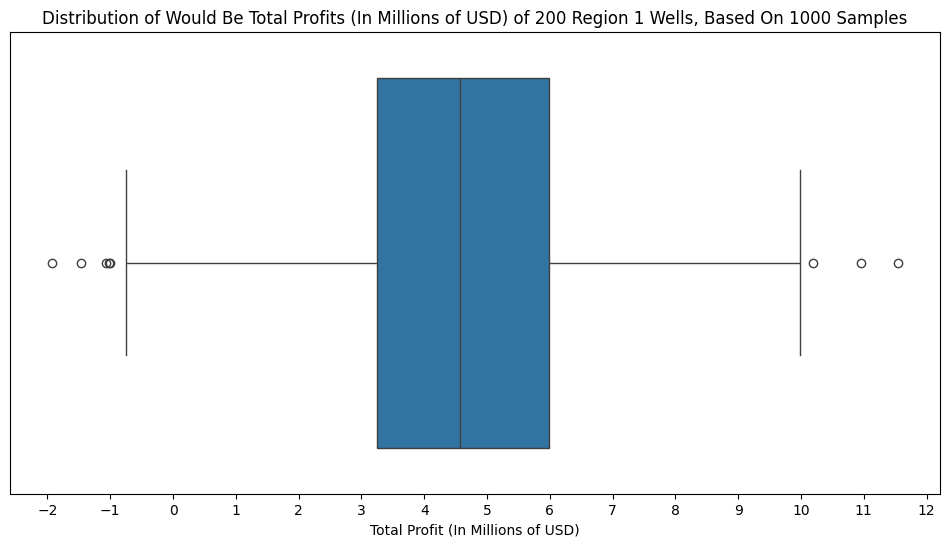

In [55]:
plt.figure(figsize = (12, 6))
sns.boxplot(data = geo_1_bootstrapped_profit_values.sum(axis = 0)/1000000, orient = 'h')

plt.title('Distribution of Would Be Total Profits (In Millions of USD) of 200 Region 1 Wells, Based On 1000 Samples')
plt.xlabel('Total Profit (In Millions of USD)')
plt.xticks([-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
plt.yticks([])
plt.show()

In [56]:
geo_1_bootstrapped_profit_values_millions = geo_1_bootstrapped_profit_values/1000000
geo_1_bootstrapped_profit_values_millions.sum(axis = 0).describe()

count    1000.000000
mean        4.560451
std         2.078466
min        -1.922681
25%         3.250479
50%         4.570359
75%         5.989760
max        11.540473
dtype: float64

In [57]:
geo_2_first_state = np.random.RandomState(12345)

geo_2_bootstrapped_profit_values = pd.DataFrame(index = range(200), columns = range(1000))
    
for k in range(1000):
    subsample = target_geo_2_valid.sample(n = 500, replace = True, random_state = geo_2_first_state)
    target_values = subsample.values
    predicted_values = predictions_geo_2_valid.loc[subsample.index].values
    profit_values = profit(target_values, predicted_values, revenue_per_product, budget_per_well)
    geo_2_bootstrapped_profit_values[k] = profit_values.reset_index(drop = True)

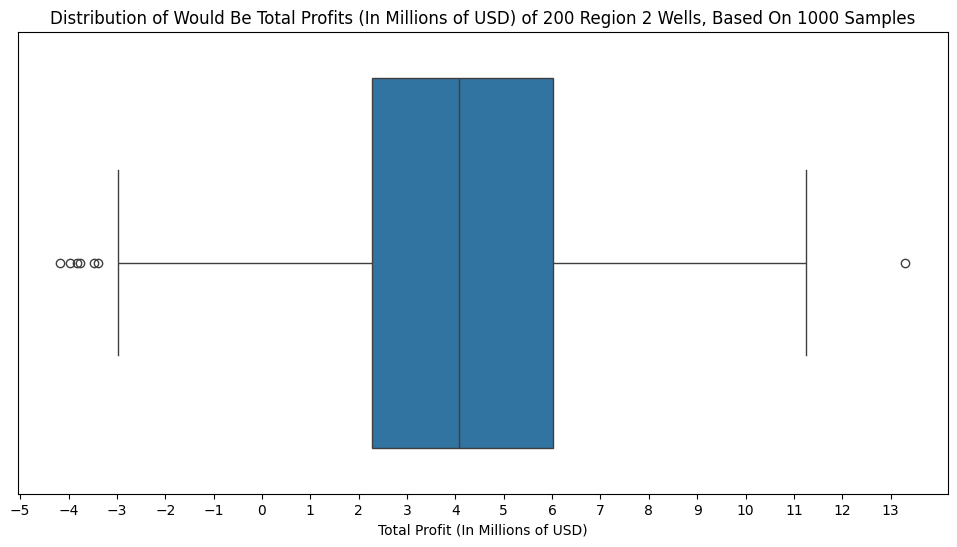

In [58]:
plt.figure(figsize = (12, 6))
sns.boxplot(data = geo_2_bootstrapped_profit_values.sum(axis = 0)/1000000, orient = 'h')

plt.title('Distribution of Would Be Total Profits (In Millions of USD) of 200 Region 2 Wells, Based On 1000 Samples')
plt.xlabel('Total Profit (In Millions of USD)')
plt.xticks([-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])
plt.yticks([])
plt.show()

In [59]:
geo_2_bootstrapped_profit_values_millions = geo_2_bootstrapped_profit_values/1000000
geo_2_bootstrapped_profit_values_millions.sum(axis = 0).describe()

count    1000.000000
mean        4.044039
std         2.732762
min        -4.178570
25%         2.281472
50%         4.072058
75%         6.019454
max        13.305932
dtype: float64

Fascinating! On the one hand, one can argue that Region 1 is the best choice because its "typical" profit values, namely the mean and median, are larger than those of Regions 0 and 2. That said, it can be argued that either Region 0 or 2 is better than Region 1 because the largest profit values of Region 0 and 2 are larger than the largest profit values of Region 1, as evidenced by how Region 1's right side whisker does not stretch out as far as those of Region 0 and 2. More investigating is needed before I make any conclusions about which region is the best one.

**<u>PART B.1</u>: Calculating the Average Profit Using a 95% Confidence Interval** <a id=6.2></a>

Since I am using a 95% confidence interval, that means the 2.5th percentile value is the lower bound, whereas the 97.5th percentile value is the upper bound.

In [60]:
geo_0_avg_profit_95_lower = geo_0_bootstrapped_profit_values.sum(axis = 0).quantile(0.025)
geo_0_avg_profit_95_upper = geo_0_bootstrapped_profit_values.sum(axis = 0).quantile(0.975)

print('I am 95% confident that the average profit OilyGiant would make per 200 wells in Region 0 is between...')
print(f"{round(geo_0_avg_profit_95_lower, 2):,}", 'and', f"{round(geo_0_avg_profit_95_upper, 2):,}", 'USD')

I am 95% confident that the average profit OilyGiant would make per 200 wells in Region 0 is between...
-1,112,155.46 and 9,097,669.42 USD


In [61]:
geo_1_avg_profit_95_lower = geo_1_bootstrapped_profit_values.sum(axis = 0).quantile(0.025)
geo_1_avg_profit_95_upper = geo_1_bootstrapped_profit_values.sum(axis = 0).quantile(0.975)

print('I am 95% confident that the average profit OilyGiant would make per 200 wells in Region 1 is between...')
print(f"{round(geo_1_avg_profit_95_lower, 2):,}", 'and', f"{round(geo_1_avg_profit_95_upper, 2):,}", 'USD')

I am 95% confident that the average profit OilyGiant would make per 200 wells in Region 1 is between...
338,205.09 and 8,522,894.54 USD


In [62]:
geo_2_avg_profit_95_lower = geo_2_bootstrapped_profit_values.sum(axis = 0).quantile(0.025)
geo_2_avg_profit_95_upper = geo_2_bootstrapped_profit_values.sum(axis = 0).quantile(0.975)

print('I am 95% confident that the average profit OilyGiant would make per 200 wells in Region 2 is between...')
print(f"{round(geo_2_avg_profit_95_lower, 2):,}", 'and', f"{round(geo_2_avg_profit_95_upper, 2):,}", 'USD')

I am 95% confident that the average profit OilyGiant would make per 200 wells in Region 2 is between...
-1,633,504.13 and 9,503,595.75 USD


Notice that Region 1 is the only region whose range of values are all positive, even the 2.5th percentile value! 

This implies that even though Region 1 does not have the largest possible profit value, it is the "safest" choice of the three regions because at least there is close to a 100% guarantee of making profit in Region 1. 

**<u>PART B.2</u>: Also Calculating the Risk of Losses (i.e. Negative Profit)** <a id=6.3></a>

In this context, calculating the risk of losses is synonymous with finding the percentage of sets of 200 locations in the region that would yield a negative profit. 

Recall that no region with a risk of losses that is at least 2.5% should even be considered.

In [63]:
geo_0_neg_profit_boolean = geo_0_bootstrapped_profit_values.sum(axis = 0).lt(0)
geo_0_neg_profit_percentage = geo_0_neg_profit_boolean.sum(axis = 0) / geo_0_bootstrapped_profit_values.shape[1] * 100

print('The risk of losses, i.e. the percentage of bootstrap iterations that would yield a negative profit, in Region 0 is:')
print(round(geo_0_neg_profit_percentage, 1), '%')

The risk of losses, i.e. the percentage of bootstrap iterations that would yield a negative profit, in Region 0 is:
6.9 %


How unfortunate! Back in Section 4, I suspected that Region 0 might be the best region because it has the most profitable top 200 locations. Unfortunately, Region 0 is simply too risky to even be worth considering. It is likely that despite having some ***very*** profitable locations, Region 0 also suffers from having too many unprofitable locations.

In [64]:
geo_1_neg_profit_boolean = geo_1_bootstrapped_profit_values.sum(axis = 0).lt(0)
geo_1_neg_profit_percentage = geo_1_neg_profit_boolean.sum(axis = 0) / geo_1_bootstrapped_profit_values.shape[1] * 100

print('The risk of losses in Region 1 is:', round(geo_1_neg_profit_percentage, 1), '%')

The risk of losses in Region 1 is: 1.5 %


Great! Region 1 still qualifies for consideration!

In [65]:
geo_2_neg_profit_boolean = geo_2_bootstrapped_profit_values.sum(axis = 0).lt(0)
geo_2_neg_profit_percentage = geo_2_neg_profit_boolean.sum(axis = 0) / geo_2_bootstrapped_profit_values.shape[1] * 100

print('The risk of losses in Region 2 is:', round(geo_2_neg_profit_percentage, 1), '%')

The risk of losses in Region 2 is: 7.6 %


Unfortunately, Region 2 is even riskier than Region 0, despite the fact that earlier in the project I found that Region 2 has the largest average **target_geo_2_valid** and **predictions_geo_2_valid values**. This suggests to me that (just like Region 0) Region 2 has too many locations that are unprofitable, to the point that the best locations cannot compensate.

**<u>PART C</u>: Suggesting a Region for Development of Oil Wells** <a id=6.4></a>

Due to how risky it would be to develop wells in Region 0 or Region 2, I have no choice but to suggest Region 1.

# Conclusion <a id=7></a>

My analysis, which includes using a linear regression model and bootstrapping, has brought me to the conclusion that **OilyGiant** stakeholders should use their budget of 100,000,000 USD to develop 200 wells in Region 1. 

Thanks to my use of bootstrapping, I came to the conclusion that the risk of losses in Region 1 is only 1.5%, meaning it is ***very*** unlikely that **OilyGiant** would lose money by picking the top 200 locations in a random sample of 500 locations in Region 1. In contrast, Regions 0 and 2 are not even worth considering because their risk of losses are 6.9% and 7.6%, respectively.

It is worth mentioning that **Section 4** of my analysis seems to suggest that Regions 0 and 2 are actually better than Region 1, since the total volume of oil in the apparent top 200 locations in Regions 0 and 2 are more than that of Region 1 (31,102 units of product in Region 0 and 29,604 units in Region 2, compared to "only" 27,746 units in Region 1). However, in addition to the high risk of losses in Regions 0 and 2, I am convinced that these results are not accurate enough to be used to decide where the 200 wells should be developed. 

Two reasons why I am skeptical of the accuracy of the results mentioned in the previous paragraph are as follows:

1) The RMSE value for Region 0's model is 37.58, which implies there are major discrepancies between many of the actual versus predicted **product** values. If that's not bad enough, the RMSE value is even larger for Region 2, 40.03. Thankfully, the RMSE value for Region 1's model is merely 0.89, which further supports my decision to suggest that region.

2) The models for Regions 0 and 2 do a bad job of approximating the standard deviations of the **product** values. The standard deviation of the volume of actual reserves in Region 0 is 44.29, whereas the model has a standard deviation of 23.18. As for Region 2, the actual and predicted standard deviation values are 44.9 and 19.85, respectively. Hence, the distributions of the predicted **product** values are much tighter than those of the actual values, meaning the model fails to accurately reflect how extreme the outliers, most notably the low outliers, of Regions 0 and 2 are. Thankfully, the actual and predicted standard deviation values for Region 1 are 46.02 and 46.01, respectively, which further suggests that Region 1's model is very accurate.

Even if the models for Regions 0 and 2 did not have the above two issues, I still would not recommend either region because it is extremely unlikely that a random sample of 500 locations, from which the best 200 are selected, would contain the 200 most profitable locations mentioned in the third paragraph. 

In short, Region 1 is, by far, the most reliable region to develop oil wells in.